In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-5", temperature=0)

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY:  ········


In [4]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Doctor(BaseModel):
    name: str = Field(
        description="Name of the doctor."
    )
    qualifications: str = Field(
        description="Qualifications of the doctor",
    )
    specialization: str = Field(
        description="Specialization of the dcotor i.e., cardiologist, dermatologist, orthopedist, etc.",
    )
    experience: int = Field(
        description="Number of years of work experience of the doctor"
    )
    description: str = Field(
        description="Description of the doctor's place of work, achievements, etc.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nQualifications: {self.qualifications}\nSpecialization: {self.specialization}\nExperience: {self.experience}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    doctors: List[Doctor] = Field(
        description="Comprehensive list of doctors with their specializations, place of work and qualifications.",
    )

class GenerateDoctorsState(TypedDict):
    symptom: str 
    max_doctors: int 
    human_feedback: str 
    doctors: List[Doctor]

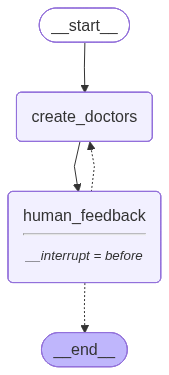

In [5]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

doctor_instructions="""You are tasked with creating a set of Doctors. Follow these instructions carefully:

1. First, take a look at the symptom: {symptom}
        
2. Examine any feedback that has been optionally provided to guide creation of the doctor personas: 
        
{human_feedback}
    
3. Determine the most suitable specialists who can diagnose the symptom {symptom}.
                    
4. Pick the top {max_doctors} specialists most suited for the symptom {symptom}.

5. Assign one doctor for each specialization."""

def create_doctors(state: GenerateDoctorsState):
    
    """ Create doctors """
    
    symptom=state['symptom']
    max_doctors=state['max_doctors']
    human_feedback=state.get('human_feedback', '')
        
    structured_llm = llm.with_structured_output(Perspectives)

    system_message = doctor_instructions.format(symptom=symptom,
                                                            human_feedback=human_feedback, 
                                                            max_doctors=max_doctors)
 
    doctors = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the list of doctors.")])

    return {"doctors": doctors.doctors}

def human_feedback(state: GenerateDoctorsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateDoctorsState):
    """ Return the next node to execute """

    human_feedback=state.get('human_feedback', None)
    if human_feedback:
        return "create_doctors"
    
    return END
 
builder = StateGraph(GenerateDoctorsState)
builder.add_node("create_doctors", create_doctors)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_doctors")
builder.add_edge("create_doctors", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_doctors", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [6]:
# Creating a list of doctors
max_doctors = 3 
symptom = "I am having a pain in my lungs"
thread = {"configurable": {"thread_id": "1"}}
doctors=()
for event in graph.stream({"symptom":symptom,"max_doctors":max_doctors,}, thread, stream_mode="values"):
    doctors = event.get('doctors', '')
    if doctors:
        for doctor in doctors:
            print(f"Name: {doctor.name}")
            print(f"Experience(in years): {doctor.experience}")
            print(f"Qualification: {doctor.qualifications}")
            print(f"Specialization: {doctor.specialization}")
            print(f"Description: {doctor.description}")
            print("-" * 50)  

Name: Dr. Maya R. Desai
Experience(in years): 15
Qualification: MD, FCCP, Board-Certified in Pulmonary Disease and Critical Care Medicine
Specialization: Pulmonologist
Description: Director of the Interstitial Lung Disease and Pleural Disorders Clinic at Riverbend University Hospital. Expertise in evaluating pleuritic chest pain, pulmonary embolism, pneumonia, and pneumothorax. Leads a multidisciplinary lung pain pathway and has authored peer-reviewed research on pleural disease and lung ultrasound.
--------------------------------------------------
Name: Dr. Alex J. Moreno
Experience(in years): 12
Qualification: MD, FACEP, ACLS/ATLS Certified
Specialization: Emergency Medicine Physician
Description: Attending physician at Central City Medical Center Emergency Department. Leads the rapid chest pain and shortness-of-breath evaluation unit with expertise in point-of-care ultrasound, acute PE protocols, and management of pneumothorax and severe pneumonia. Known for streamlined triage of p

In [7]:
state = graph.get_state(thread)
state.next

('human_feedback',)

In [8]:
graph.update_state(thread, {"human_feedback": 
                            "Add a Lung cancer specialist"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0cdcb6-8d21-6cb9-8002-b1efd09c1069'}}

In [9]:
for event in graph.stream(None, thread, stream_mode="values"):
    doctors = event.get('doctors', '')
    if doctors:
        for doctor in doctors:
            print(f"Name: {doctor.name}")
            print(f"Experience(in years): {doctor.experience}")
            print(f"Qualification: {doctor.qualifications}")
            print(f"Specialization: {doctor.specialization}")
            print(f"Description: {doctor.description}")
            print("-" * 50)

Name: Dr. Maya R. Desai
Experience(in years): 15
Qualification: MD, FCCP, Board-Certified in Pulmonary Disease and Critical Care Medicine
Specialization: Pulmonologist
Description: Director of the Interstitial Lung Disease and Pleural Disorders Clinic at Riverbend University Hospital. Expertise in evaluating pleuritic chest pain, pulmonary embolism, pneumonia, and pneumothorax. Leads a multidisciplinary lung pain pathway and has authored peer-reviewed research on pleural disease and lung ultrasound.
--------------------------------------------------
Name: Dr. Alex J. Moreno
Experience(in years): 12
Qualification: MD, FACEP, ACLS/ATLS Certified
Specialization: Emergency Medicine Physician
Description: Attending physician at Central City Medical Center Emergency Department. Leads the rapid chest pain and shortness-of-breath evaluation unit with expertise in point-of-care ultrasound, acute PE protocols, and management of pneumothorax and severe pneumonia. Known for streamlined triage of p

In [10]:
further_feedack = None
graph.update_state(thread, {"human_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0cdcb9-3abf-654f-8004-317659a5bc4d'}}

In [11]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [12]:
final_state = graph.get_state(thread)
doctors = final_state.values.get('doctors')

In [13]:
final_state.next

()

In [14]:
for doctor in doctors:
    print(f"Name: {doctor.name}")
    print(f"Experience(in years): {doctor.experience}")
    print(f"Qualification: {doctor.qualifications}")
    print(f"Specialization: {doctor.specialization}")
    print(f"Description: {doctor.description}")
    print("-" * 50) 

Name: Dr. Aisha Raman, MD, FCCP
Experience(in years): 15
Qualification: MD; Fellowship in Pulmonary & Critical Care Medicine; FCCP
Specialization: Pulmonologist
Description: Senior consultant at Metropolitan Respiratory & Critical Care Institute. Expert in evaluating pleuritic chest pain, pneumonia, pulmonary embolism, pneumothorax, and musculoskeletal chest wall disorders. Performs advanced diagnostics including thoracic ultrasound, spirometry, bronchoscopy, and cardiopulmonary exercise testing. Leads a rapid-access chest clinic and has publications in CHEST and the American Journal of Respiratory and Critical Care Medicine.
--------------------------------------------------
Name: Dr. Marco Alvarez, MD, MS, FACP
Experience(in years): 14
Qualification: MD; MS in Clinical Research; Fellowship in Hematology/Oncology; FACP
Specialization: Lung Cancer Specialist
Description: Thoracic medical oncologist at Harborview Comprehensive Cancer Center, focusing on early detection and treatment of 

In [15]:
# planning on arriving at result with the help of debates between the professionals.
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class DebateState(MessagesState):
    max_num_turns: int 
    context: Annotated[list, operator.add] 
    doctor1: Doctor
    doctor2: Doctor
    doctor3: Doctor
    debate: str 
    sections: list 

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [16]:
debate_instructions = """You are to initiate a discussion between multiple doctors to diagnose the given symptom. 

Your goal is to get all of them to justify their approach and try to convince the other doctors why their way is the best. Be open to all ideas and decide the best way.

1. Take turns: Have a back and forth with the other specialists on how to diagnose and treat the symptom.
        
2. Specific: Insights that avoid generalities and include specific knowledge from each induviduals field.

Here is your topic of focus and set of goals for each doctor: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then make your case.

Continue to ask questions to drill down and refine your treatment plan for the patient.

You are to make judgments based on just the symptoms of the patient, if there is any uncertainty (i.e. gender, age, history), you are to provide answers for all cases to be as all-encompassing as possible
        
When you are satisfied with your plan, complete the debate with: "Thank you!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_discussion(state: DebateState):
    """ Node to generate a discussion """

    doctor1 = state["doctor1"]
    doctor2 = state["doctor2"]
    doctor3 = state["doctor3"]
    messages = state["messages"]
 
    system_message = debate_instructions.format(goals={doctor1.persona,doctor2.persona,doctor3.persona})
    sentence = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    return {"messages": [sentence]}

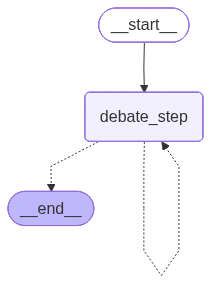

In [17]:
# testing out a smaple debate by making a temporary graph for debate

builder = StateGraph(DebateState)

builder.add_node("debate_step", generate_discussion)
builder.add_edge(START, "debate_step")
def should_continue(state):
    # stop if "Thank you!" appears OR turns exceeded
    last_message = state["messages"][-1].content.lower()

    if "thank you" in last_message:
        return END
    if len(state["messages"]) >= state["max_num_turns"]:
        return END
    return "debate_step"
builder.add_conditional_edges(
    "debate_step",
    should_continue,
    ["debate_step", END]
)

memory = MemorySaver()
graph = builder.compile(interrupt_before=[], checkpointer=memory)

from IPython.display import Image, display

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [18]:
# Input
doctor1=doctors[0]
doctor2=doctors[1]
doctor3=doctors[2]
max_num_turns = 15
topic = "Treating the symptom"
thread = {"configurable": {"thread_id": "2"}}
initial_state = {
    "messages": [
        {"role": "user", "content": "The patient has pleuritic chest pain and cough."}
    ],
    "doctor1": doctor1,
    "doctor2": doctor2,
    "doctor3": doctor3,
    "context": [],
    "max_num_turns": max_num_turns,
    "debate": topic,
    "sections": []
}


for event in graph.stream(initial_state, thread, stream_mode="values"):
    if "messages" in event:
        print("\n----------------------------------------------")
        print(event["messages"][-1].content)


----------------------------------------------
The patient has pleuritic chest pain and cough.

----------------------------------------------
I’m Dr. Aisha Raman, pulmonologist. With pleuritic chest pain plus cough, my first priorities are to rule out the immediately dangerous: pulmonary embolism (PE), pneumothorax, pneumonia with sepsis/empyema, and pericarditis. Then I’ll separate chest wall causes from pleural/lung pathology. I’ll press for a structured, risk-based pathway to avoid missing PE and not over-CT everyone.

I’m Dr. Emily Chen, cardiothoracic surgeon. I’m looking for structural problems I can fix: spontaneous or secondary pneumothorax, complicated parapneumonic effusion/empyema, chest wall pathology, or malignant pleural disease that needs a procedure. I want an early bedside lung ultrasound; it’s faster than X-ray for pneumothorax/effusion and guides immediate drainage if needed.

I’m Dr. Marco Alvarez, thoracic medical oncologist. While infection and PE are common, I 

In [19]:
# integration of web search

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

TAVILY_API_KEY:  ········


In [20]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

C:\Users\hp\AppData\Local\Temp\ipykernel_34868\3381304624.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


In [21]:
from langchain_community.document_loaders import WikipediaLoader

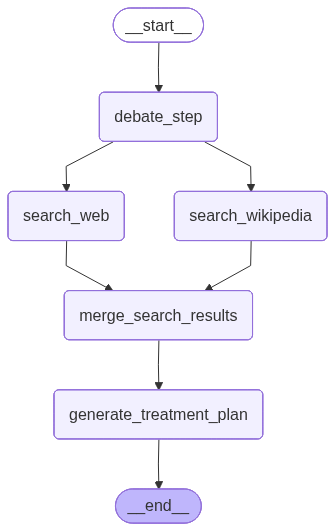

In [24]:
from langchain_core.messages import get_buffer_string

search_instructions = SystemMessage(content=f"""You will be given a conversation between medical experts diagnosing a symptom. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the treatment plan posed by each doctor.

Verify this final plan using a well-structured web search query""")

def search_web(state: DebateState):

    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state['messages'])

    search_docs = tavily_search.invoke(search_query.search_query)

    if isinstance(search_docs, dict) and "results" in search_docs:
        search_docs = search_docs["results"]

    formatted = []

    for doc in search_docs:
        if isinstance(doc, dict):
            url = doc.get("url", "unknown")
            content = doc.get("content", str(doc))
            formatted.append(
                f'<Document href="{url}">\n{content}\n</Document>'
            )
        else:
            formatted.append(
                f'<Document>\n{str(doc)}\n</Document>'
            )

    return {"context": ["\n\n---\n\n".join(formatted)]}


def search_wikipedia(state: DebateState):
    
    """ Retrieve docs from wikipedia """

    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=3).load()

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def merge_search_results(state: DebateState):
    merged = "\n\n".join(state["context"])
    return {"context": [merged]}

def generate_treatment_plan(state: DebateState):
    """
    Node that merges:
    - all debate conversation
    - web + wikipedia search context
    and generates a final, unified medical treatment plan.
    """

    messages = state["messages"]            
    context_list = state.get("context", []) 
    debate_topic = state.get("debate", "")  
    
    context_text = "\n\n".join(context_list) if context_list else "No external context available."
    
    system_message = """You are a panel lead physician tasked with producing the *final medical treatment plan based on:

    1. The entire debate between specialists.
    2. The combined search context (clinical guidelines, web results, wikipedia summaries).
    3. The patient’s main complaint: {debate_topic}

    Your output must be:

    - Structured
    - Evidence-based
    - Reflective of the discussion points raised by all specialists
    - Clear and clinically actionable

    DO NOT repeat the debate.
    DO NOT repeat the search results.
    Synthesize everything into a **single, authoritative treatment plan**.

    Include:
    - Primary diagnosis or differential
    - Recommended diagnostic tests with justification
    - Initial treatment
    - Follow-up considerations
    - Any red flags or escalation scenarios

Finish with: “Final plan complete.”
"""

    final_response = llm.invoke([SystemMessage(content=system_message)] + messages)
    final_response.name = "treatment_plan"

    return {"messages": [final_response]}




# Add nodes and edges 
debate_builder = StateGraph(DebateState)
debate_builder.add_node("debate_step", generate_discussion)
debate_builder.add_node("search_web", search_web)
debate_builder.add_node("search_wikipedia", search_wikipedia)
debate_builder.add_node("merge_search_results", merge_search_results)
debate_builder.add_node("generate_treatment_plan", generate_treatment_plan)

# Flow
debate_builder.add_edge(START, "debate_step")
debate_builder.add_edge("debate_step", "search_web")
debate_builder.add_edge("debate_step", "search_wikipedia")
debate_builder.add_edge("search_web", "merge_search_results")
debate_builder.add_edge("search_wikipedia", "merge_search_results")
debate_builder.add_edge("merge_search_results", "generate_treatment_plan")
debate_builder.add_edge("generate_treatment_plan", END)

# debate 
memory = MemorySaver()
debate_graph = debate_builder.compile(checkpointer=memory).with_config(run_name="Conduct Debate")

# View
display(Image(debate_graph.get_graph().draw_mermaid_png()))

In [26]:
# Input
doctor1=doctors[0]
doctor2=doctors[1]
doctor3=doctors[2]
max_num_turns = 15
topic = "Treating the symptom"
thread = {"configurable": {"thread_id": "2"}}
initial_state = {
    "messages": [
        {"role": "user", "content": "The patient has pleuritic chest pain and cough."}
    ],
    "doctor1": doctor1,
    "doctor2": doctor2,
    "doctor3": doctor3,
    "context": [],
    "max_num_turns": max_num_turns,
    "debate": topic,
    "sections": []
}


final_plan = None

for event in debate_graph.stream(initial_state, thread, stream_mode="values"):
    if "messages" in event:
        msg = event["messages"][-1]

        if getattr(msg, "name", None) == "treatment_plan":
            final_plan = msg.content

# Print only the final treatment plan
print(final_plan)


Final Medical Treatment Plan

Primary diagnosis and differential
- Priorities to exclude first (life-threatening):
  - Pulmonary embolism (PE)
  - Pneumothorax (including tension)
  - Complicated parapneumonic effusion/empyema
- Other likely/important causes:
  - Community-acquired pneumonia (CAP) with pleurisy
  - Acute pericarditis/myopericarditis
  - Viral pleuritis
  - Musculoskeletal chest wall pain (costochondritis) after coughing
  - Less common but consider: malignant pleural involvement, tuberculosis, autoimmune pleuritis

Recommended diagnostic tests with justification
Immediate triage and bedside evaluation (for all patients)
- Vitals with pulse oximetry and work of breathing: identify hypoxia or instability that requires ED/hospital care.
- ECG: screens for pericarditis (diffuse ST elevation/PR depression), right heart strain from PE, or alternate cardiac pathology.
- Chest X-ray (upright if possible): detects consolidation, pleural effusion, pneumothorax, or masses; guides